# VAR

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
df = pd.read_csv("salesdaily.csv", parse_dates=['datum'])
df["date"] = pd.to_datetime(df['datum'])
df.set_index(df['date'], inplace=True)
df=df[["M01AB","M01AE","N02BA","N02BE","N05B","N05C","R03","R06"]]
print(df.shape)  # (123, 8)
df.tail()
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

(2106, 8)


## Visualize the Time Series

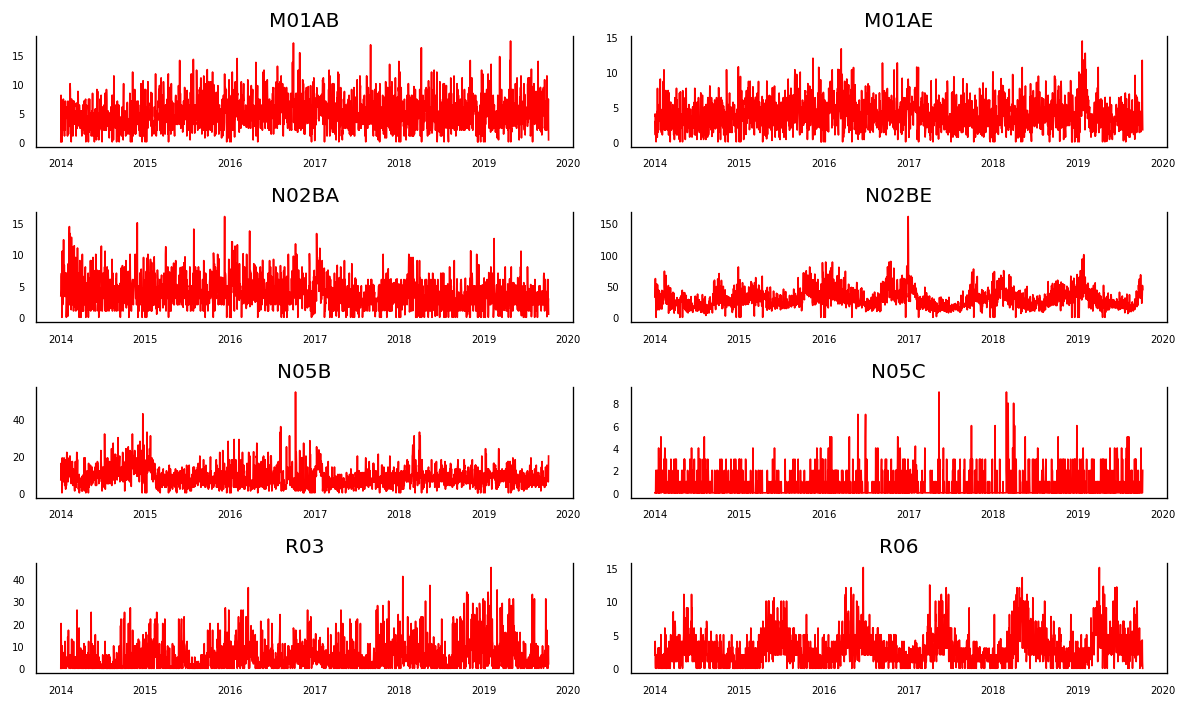

In [2]:

fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

## Testing Causation using Granger’s Causality Test


In [3]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=35
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

,M01AB_x,M01AE_x,N02BA_x,N02BE_x,N05B_x,N05C_x,R03_x,R06_x
M01AB_y,1.0000,0.0028,0.0004,0.0000,0.0393,0.2445,0.2399,0.1905
M01AE_y,0.0063,1.0000,0.0019,0.0000,0.0087,0.3397,0.0434,0.0159
N02BA_y,0.0327,0.1924,1.0000,0.0000,0.0001,0.2654,0.0836,0.0001
N02BE_y,0.0141,0.1448,0.0230,1.0000,0.0195,0.1071,0.0001,0.0000
N05B_y,0.0030,0.0298,0.0323,0.0000,1.0000,0.0057,0.3601,0.0000
N05C_y,0.0026,0.2146,0.7085,0.0271,0.0000,1.0000,0.4258,0.0812
R03_y,0.1257,0.0037,0.1865,0.0000,0.2041,0.0015,1.0000,0.1322
R06_y,0.6268,0.0025,0.0111,0.0000,0.0007,0.0036,0.0087,1.0000


The row are the Response (Y) and the columns are the predictor series (X).

If a given p-value is $\leq$ significance level ($ \alpha =.05$), then, the corresponding X series (column) causes the Y (row).

Looking at the p-values in the above table, several variables cause each other. We can continue to do the Cointegration test.

## Cointegration Test

Cointegration test helps to establish the presence of a statistically significant connection between two or more time series.
When two or more time series are cointegrated, it means they have a long run, statistically significant relationship.

This is the basic premise on which Vector Autoregression(VAR) models is based on.

Johanssen (1991) test will be used to implement the cointegration.

In [4]:

from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
M01AB  ::  1394.26   > 143.6691  =>   True
M01AE  ::  1035.49   > 111.7797  =>   True
N02BA  ::  784.49    > 83.9383   =>   True
N02BE  ::  541.88    > 60.0627   =>   True
N05B   ::  339.07    > 40.1749   =>   True
N05C   ::  168.32    > 24.2761   =>   True
R03    ::  49.14     > 12.3212   =>   True
R06    ::  3.45      > 4.1296    =>   False


All the series are cointegrated except the R06.

## Split the Series into Training and Testing Data

The VAR model will be fitted on df_train and then used to forecast the next 10% observations. These forecasts will be compared against the actuals present in test data.

In [5]:
split_index = int(len(df)*0.80)
df_train = df.iloc[:split_index,:]
df_test = df.iloc[split_index:,:]
print('Train: {} | Test: {}'.format(df_train.shape, df_test.shape))
# Check size
print(df_train.shape)  # (1684, 8)
print(df_test.shape)  # (422, 8)
nobs=422

Train: (1684, 8) | Test: (422, 8)
(1684, 8)
(422, 8)


## Check for Stationarity

Augmented Dickey-Fuller Test (ADF Test) to test for stationarity.


In [6]:

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [7]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "M01AB" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.15
 No. Lags Chosen       = 14
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "M01AE" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.8825
 No. Lags Chosen       = 21
 Critical value 1%     = -3.434
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "N02BA" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.

All of the series in the VAR model should have the same number of observations. And since all are stationary, we can proceed.

## Select the Order (P) of VAR model

To select the right order of the VAR model, we iteratively fit increasing orders of VAR model and pick the order that gives a model with least AIC.

Though the usual practice is to look at the AIC, you can also check other best fit comparison estimates of BIC, FPE and HQIC.



In [8]:
model = VAR(df_train)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')


Lag Order = 1
AIC :  18.84067082757138
BIC :  19.072898985611626
FPE :  152194770.46547154
HQIC:  18.926685929090016 

Lag Order = 2
AIC :  18.708891402598137
BIC :  19.147757325494972
FPE :  133404564.74420065
HQIC:  18.87144802784863 

Lag Order = 3
AIC :  18.66549772721732
BIC :  19.311201966766234
FPE :  127740992.15056793
HQIC:  18.904674744511397 

Lag Order = 4
AIC :  18.645591474048302
BIC :  19.498334899710738
FPE :  125226155.54737887
HQIC:  18.961467880170755 

Lag Order = 5
AIC :  18.640549687073303
BIC :  19.700533486669155
FPE :  124601023.05743419
HQIC:  19.033204607566926 

Lag Order = 6
AIC :  18.612507148463607
BIC :  19.87993282886566
FPE :  121162117.4483663
HQIC:  19.082019837914945 

Lag Order = 7
AIC :  18.519458022317465
BIC :  19.99452741014775
FPE :  110405177.73393676
HQIC:  19.065907864643364 

Lag Order = 8
AIC :  18.53873815701416
BIC :  20.221653399342237
FPE :  112565918.48245682
HQIC:  19.16220466574911 

Lag Order = 9
AIC :  18.570778128002708
BIC :  2

In the above output, the AIC drops to lowest at lag 7, then increases at lag 8 and then continuously drops further.

Let’s go with the lag 7 model.

An alternate method to choose the order(p) of the VAR models is to use the model.select_order(maxlags) method.

The selected order(p) is the order that gives the lowest ‘AIC’, ‘BIC’, ‘FPE’ and ‘HQIC’ scores.

In [9]:
x = model.select_order(maxlags=15)
x.summary()

,AIC,BIC,FPE,HQIC
0,19.31,19.34,2.431e+08,19.32
1,18.83,19.07*,1.513e+08,18.92
2,18.70,19.15,1.328e+08,18.87*
3,18.66,19.31,1.273e+08,18.90
4,18.64,19.50,1.243e+08,18.96
5,18.63,19.70,1.235e+08,19.03
6,18.61,19.88,1.210e+08,19.08
7,18.52*,20.00,1.107e+08*,19.07
8,18.54,20.23,1.126e+08,19.17
9,18.57,20.47,1.162e+08,19.27


The AIC and the FPE are congruent with the previous decision.

So let's use 7 lags.


## Train the VAR model fo selected order (7)

In [10]:
model_fitted = model.fit(7)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 19, Jun, 2021
Time:                     01:50:59
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    19.9945
Nobs:                     1677.00    HQIC:                   19.0659
Log likelihood:          -34109.0    FPE:                1.10405e+08
AIC:                      18.5195    Det(Omega_mle):     8.45009e+07
--------------------------------------------------------------------
Results for equation M01AB
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            2.804136         0.460516            6.089           0.000
L1.M01AB         0.052318         0.025627            2.042           0.041
L1.M01AE         0.091091         0.033364            2.730           0.006
L1.N

## Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors).

If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model.

The Durbin Watson’s Statistic will be used, Durbin Watson Statistic - Formula:

$$DW=\frac{\sum_{t=2}^{T}((e_t - e_{t-1})^2)}{\sum_{t=1}^{T}e^2_t}$$

The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [11]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

M01AB : 1.99
M01AE : 1.99
N02BA : 2.01
N02BE : 2.02
N05B : 2.0
N05C : 2.01
R03 : 2.01
R06 : 2.0


The serial correlation presents no problems.


In [12]:
# check for residuals serial correlation
white_test5 = model_fitted.test_whiteness(nlags=8, adjusted=True)
white_test5.summary()

Test statistic,Critical value,p-value,df
148.2,83.68,0.000,64


In [13]:
# ARCH effect
from statsmodels.stats.diagnostic import het_arch

Teste_arch5 = het_arch(model_fitted.resid.iloc[:,1], nlags=8)


print('ARCH test for heteroskedasticity:')
print("P-Value stats 1:",Teste_arch5[1])
print("P-Value stas 2:",Teste_arch5[3])

ARCH test for heteroskedasticity:
P-Value stats 1: 0.09408931148184416
P-Value stas 2: 0.09390063370658346


In [14]:
# check if residuals are normally distributed
norm_test2 = model_fitted.test_normality()
norm_test2.summary()

Test statistic,Critical value,p-value,df
1.355e+04,26.30,0.000,16


## Forecast I

In order to forecast, the VAR model expects up to the lag order number of observations from the past data.

In [15]:
lagged_values=df_train.values[-7:]

In [16]:
z = model_fitted.forecast(y=lagged_values, steps=nobs)

df_forecast=pd.DataFrame(data=z, columns=['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06'])

df_forecast

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,5.136911,3.839547,4.017455,23.629198,8.119473,0.365888,4.014037,3.606029
1,4.269193,3.410228,4.140479,18.722974,10.742078,0.536522,4.146922,3.550872
2,4.535262,3.320954,3.405104,19.076373,9.850585,0.830541,2.854739,3.279645
3,5.323574,3.371307,3.756051,22.747186,7.795502,0.424799,2.218604,3.843638
4,5.010276,3.889120,3.840030,21.940595,7.691641,0.287430,4.275440,3.364069
...,...,...,...,...,...,...,...,...
417,4.980390,3.907308,4.075286,29.470253,8.896703,0.565147,4.899909,2.837506
418,4.980390,3.907308,4.075286,29.470254,8.896703,0.565147,4.899909,2.837506
419,4.980390,3.907308,4.075286,29.470254,8.896703,0.565147,4.899909,2.837506
420,4.980390,3.907308,4.075286,29.470255,8.896703,0.565147,4.899909,2.837506


<AxesSubplot:>

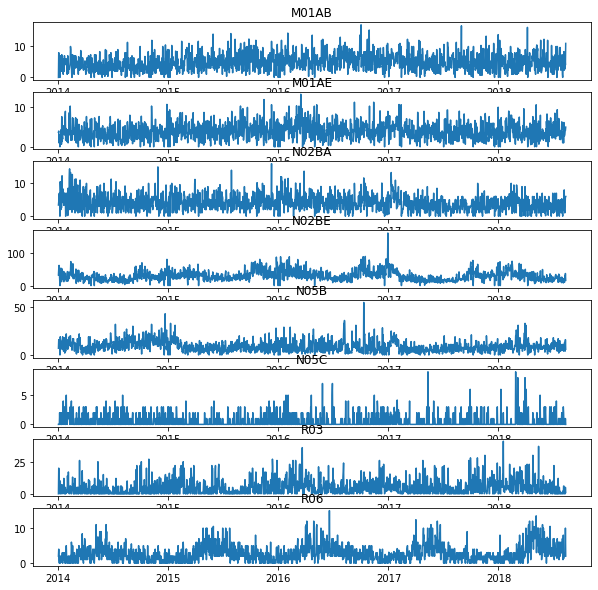

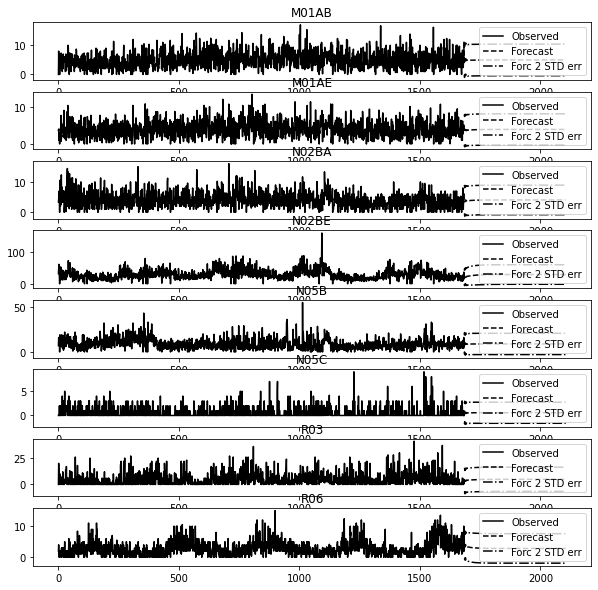

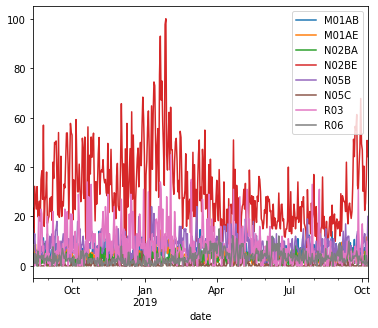

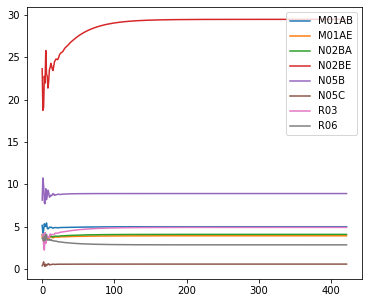

In [17]:

model_fitted.plot();

model_fitted.plot_forecast(nobs);

test_range=df[-nobs:]

test_range.plot(figsize=(6,5))

df_forecast.plot(figsize=(6,5))

In [18]:
# rmse(actual, predicted)
RMSE1 = rmse(df['M01AB'][-nobs:], df_forecast['M01AB'])
print(f'M01AB VAR(7) RMSE: {RMSE1:.3f}')

M01AB VAR(7) RMSE: 2.810


In [19]:

RMSE1 = rmse(df['M01AE'][-nobs:], df_forecast['M01AE'])
print(f'M01AE VAR(7) RMSE: {RMSE1:.3f}')

M01AE VAR(7) RMSE: 2.263


In [20]:
RMSE1 = rmse(df['N02BA'][-nobs:], df_forecast['N02BA'])
print(f'N02BA VAR(7) RMSE: {RMSE1:.3f}')

N02BA VAR(7) RMSE: 2.194


In [21]:
RMSE1 = rmse(df['N02BE'][-nobs:], df_forecast['N02BE'])
print(f'N02BE VAR(7) RMSE: {RMSE1:.3f}')

N02BE VAR(7) RMSE: 15.983


In [22]:
RMSE1 = rmse(df['N05B'][-nobs:], df_forecast['N05B'])
print(f'N05B VAR(7) RMSE: {RMSE1:.3f}')  

N05B VAR(7) RMSE: 4.208


In [23]:
RMSE1 = rmse(df['N05C'][-nobs:], df_forecast['N05C'])
print(f'N05C VAR(7) RMSE: {RMSE1:.3f}')

N05C VAR(7) RMSE: 1.110


In [24]:
RMSE1 = rmse(df['R03'][-nobs:], df_forecast['R03'])
print(f'R03 VAR(7) RMSE: {RMSE1:.3f}')

R03 VAR(7) RMSE: 8.699


In [25]:
RMSE1 = rmse(df['R06'][-nobs:], df_forecast['R06'])
print(f'R06 VAR(7) RMSE: {RMSE1:.3f}')

R06 VAR(7) RMSE: 2.573


## Forecast II

In [26]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 7

# Input data for forecasting
forecast_input = df_train.values[-lag_order:]
forecast_input

7


array([[ 8.33 ,  6.165,  2.   , 21.388,  7.   ,  0.   ,  6.   ,  2.   ],
       [ 2.33 ,  2.67 ,  8.   , 15.   ,  7.   ,  1.   ,  1.   ,  3.   ],
       [ 4.33 ,  2.793,  2.   , 10.   , 13.   ,  0.   ,  0.   ,  2.   ],
       [ 2.67 ,  3.066,  1.   , 29.4  , 13.   ,  0.   ,  0.   ,  2.   ],
       [ 6.   ,  4.   ,  4.   , 19.   ,  4.   ,  0.   ,  0.   ,  2.   ],
       [ 4.   ,  4.133,  6.   , 37.   , 16.   ,  1.   ,  5.   , 10.   ],
       [10.99 ,  4.99 ,  6.   , 16.   ,  6.   ,  0.   ,  1.   ,  2.   ]])

In [27]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_forecast')
df_forecast

,M01AB_forecast,M01AE_forecast,N02BA_forecast,N02BE_forecast,N05B_forecast,N05C_forecast,R03_forecast,R06_forecast
date,,,,,,,,
2018-08-13,5.136911,3.839547,4.017455,23.629198,8.119473,0.365888,4.014037,3.606029
2018-08-14,4.269193,3.410228,4.140479,18.722974,10.742078,0.536522,4.146922,3.550872
2018-08-15,4.535262,3.320954,3.405104,19.076373,9.850585,0.830541,2.854739,3.279645
2018-08-16,5.323574,3.371307,3.756051,22.747186,7.795502,0.424799,2.218604,3.843638
2018-08-17,5.010276,3.889120,3.840030,21.940595,7.691641,0.287430,4.275440,3.364069
...,...,...,...,...,...,...,...,...
2019-10-04,4.980390,3.907308,4.075286,29.470253,8.896703,0.565147,4.899909,2.837506
2019-10-05,4.980390,3.907308,4.075286,29.470254,8.896703,0.565147,4.899909,2.837506
2019-10-06,4.980390,3.907308,4.075286,29.470254,8.896703,0.565147,4.899909,2.837506


## Plot of Forecast vs Actuals


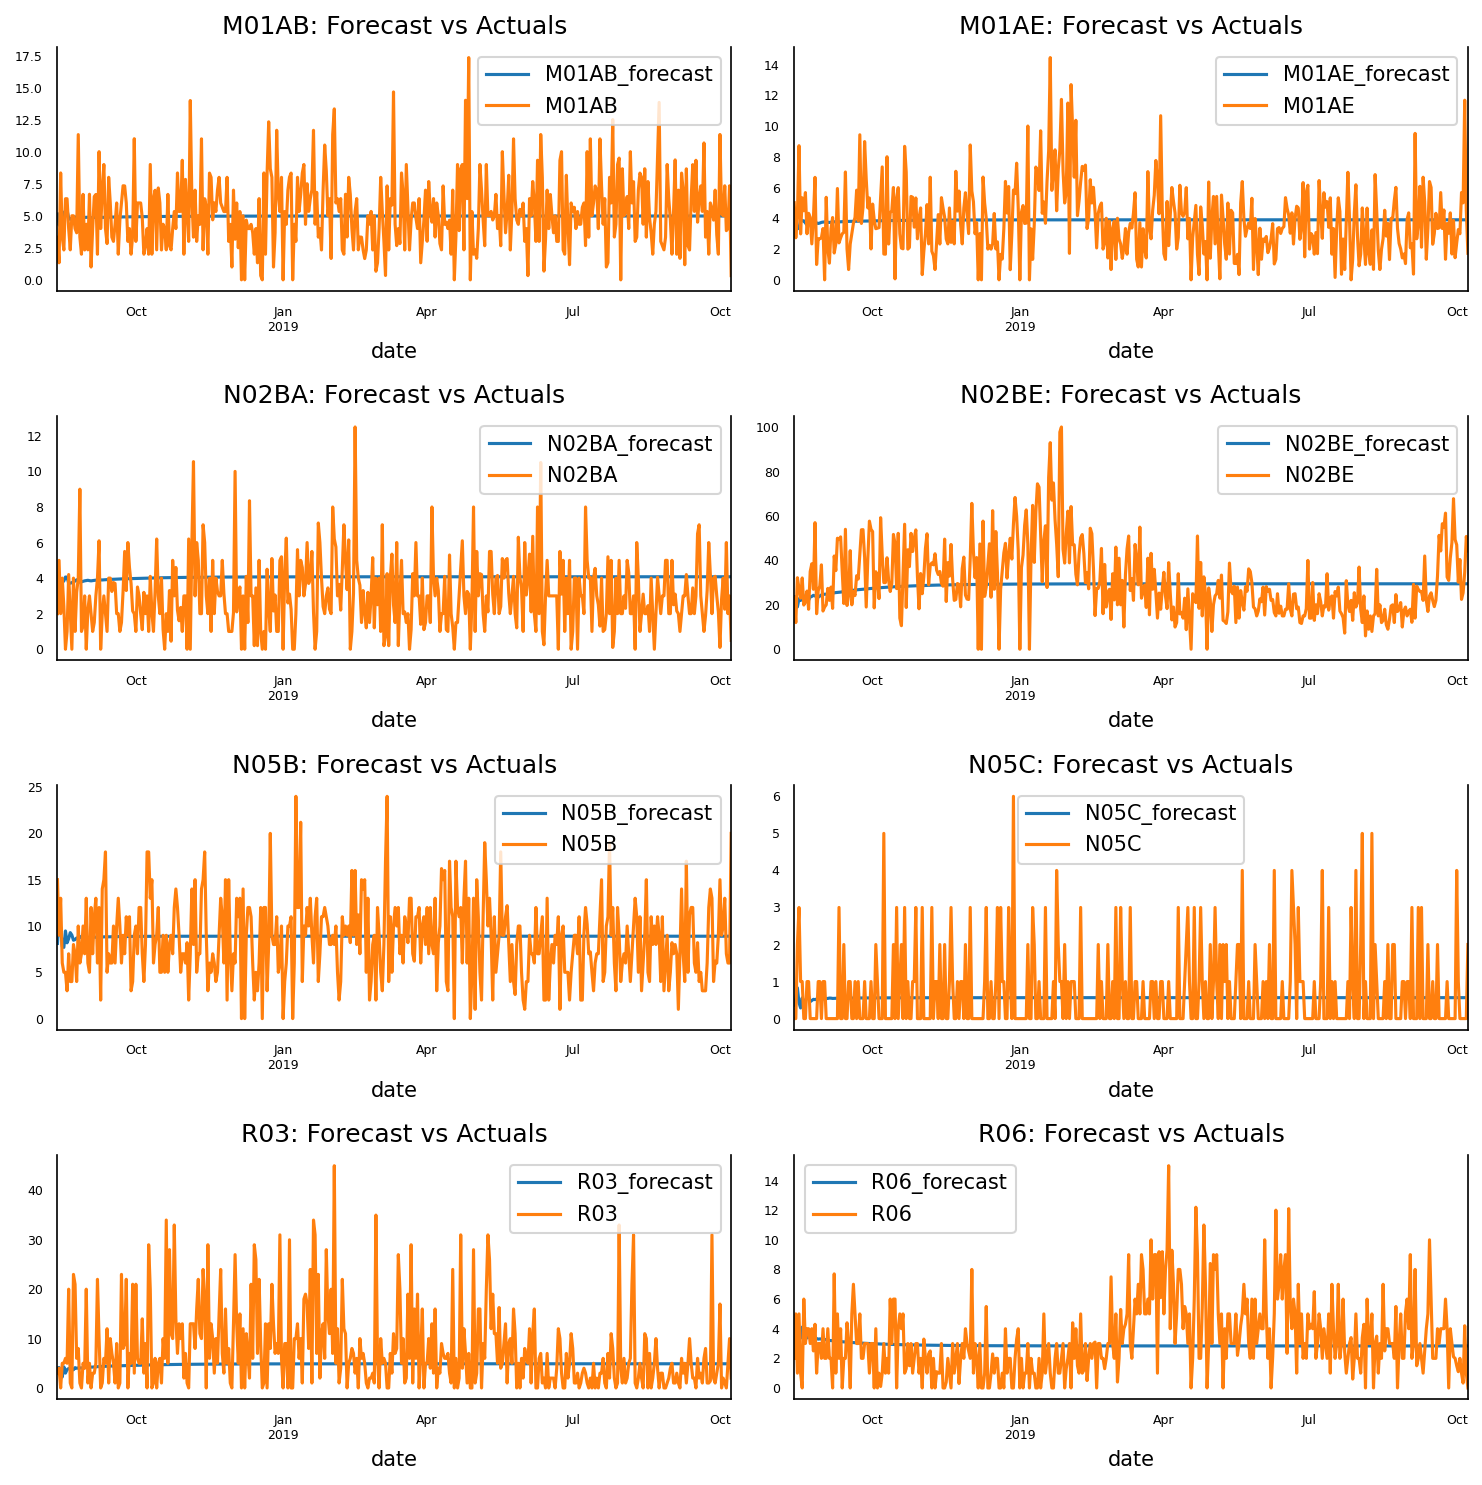

In [28]:
df_results=df_forecast
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Forecast vs Actuals comparison of VAR model


## Evaluate the Forecasts

To evaluate the forecasts, let’s compute a comprehensive set of metrics, namely, the MAPE, ME, MAE, MPE, RMSE, corr and minmax.

In [29]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: M01AB')
accuracy_prod = forecast_accuracy(df_results['M01AB_forecast'].values, df_test['M01AB'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: M01AE')
accuracy_prod = forecast_accuracy(df_results['M01AE_forecast'].values, df_test['M01AE'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: N02BA')
accuracy_prod = forecast_accuracy(df_results['N02BA_forecast'].values, df_test['N02BA'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: N02BE')
accuracy_prod = forecast_accuracy(df_results['N02BE_forecast'].values, df_test['N02BE'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: N05B')
accuracy_prod = forecast_accuracy(df_results['N05B_forecast'].values, df_test['N05B'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: N05C')
accuracy_prod = forecast_accuracy(df_results['N05C_forecast'].values, df_test['N05C'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: R03')
accuracy_prod = forecast_accuracy(df_results['R03_forecast'].values, df_test['R03'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: R06')
accuracy_prod = forecast_accuracy(df_results['R06_forecast'].values, df_test['R06'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: M01AB
mape :  inf
me :  -0.2969
mae :  2.1825
mpe :  inf
rmse :  2.8102
corr :  0.0564
minmax :  0.3345

Forecast Accuracy of: M01AE
mape :  inf
me :  0.0369
mae :  1.7386
mpe :  inf
rmse :  2.2635
corr :  -0.0166
minmax :  0.3532

Forecast Accuracy of: N02BA
mape :  inf
me :  1.0171
mae :  1.7997
mpe :  inf
rmse :  2.1943
corr :  0.0591
minmax :  0.4078

Forecast Accuracy of: N02BE
mape :  inf
me :  -1.781
mae :  12.3528
mpe :  inf
rmse :  15.9831
corr :  -0.0206
minmax :  0.3214

Forecast Accuracy of: N05B
mape :  inf
me :  0.3447
mae :  3.3771
mpe :  inf
rmse :  4.2081
corr :  0.0287
minmax :  0.3185

Forecast Accuracy of: N05C
mape :  inf
me :  -0.1352
mae :  0.8258
mpe :  inf
rmse :  1.11
corr :  0.0528
minmax :  0.8443

Forecast Accuracy of: R03
mape :  inf
me :  -2.9808
mae :  5.8407
mpe :  inf
rmse :  8.6987
corr :  0.022
minmax :  0.5697

Forecast Accuracy of: R06
mape :  inf
me :  -0.4164
mae :  1.9036
mpe :  inf
rmse :  2.5729
corr :  -0.0801
minmax :  